# Example defect analysis using py-sc-Fermi

**Important:** the underlying data here generated using VASP, is not expected to be chemically accurate, it does not use an appropriate level of theory for accurate electronic structure calculations in the context of point defects, nor are the energies corrected, it was merely generated to serve as a minimal working example (MWE) for the functionalilty of `py-sc-Fermi`. For best practice in defect chemistry calculations, see e.g.:

- https://doi.org/10.1088/2515-7655/aba081
- https://doi.org/10.1103/RevModPhys.86.253

The cells below show a basic point-defect analysis workflow using `py-sc-Fermi`

## 1. Generate raw data

`py-sc-fermi` was developed by VASP users, and so there is a natural bias towards convenitenly parsing VASP calcualtion output to automate various aspects of the analysis, however, fundamentally there is nothing stopping any other code being used. If you would like to regenerate the raw data used in this notebook, this can be done via running the calculation inputs which are generated in the cell below.

In [1]:
from pymatgen.core import Structure
from copy import deepcopy

host = Structure.from_file('LiF_mp-1138_conventional_standard.cif')
host.make_supercell(2)

Li_vacancy = deepcopy(host)
Li_vacancy.remove_sites([0])
F_vacancy = deepcopy(host)
F_vacancy.remove_sites([32])

from pymatgen.io.vasp.sets import MPRelaxSet

host_calc = MPRelaxSet(host, user_incar_settings={'ISIF':2, 'EDIFFG':-0.05})
Li_vacancy_calc = MPRelaxSet(Li_vacancy, user_incar_settings={'ISIF':2, 'EDIFFG':-0.05, 'NELECT':318})
F_vacancy_calc = MPRelaxSet(F_vacancy, user_incar_settings={'ISIF':2, 'EDIFFG':-0.05, 'NELECT':312})

Li_vacancy_calc.write_input('v_Li')
F_vacancy_calc.write_input('v_F')
host_calc.write_input('host')

/home/alex/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pymatgen/io/vasp/sets.py:129: BadInputSetWarning: POTCAR data with symbol Li_sv is not known by pymatgen to                    correspond with the selected potcar_functional PBE. This POTCAR                    is known to correspond with functionals ['PBE_52', 'unvie_PBE_52', 'PBE_54']. Please verify that                    you are using the right POTCARs!
  warnings.warn(
/home/alex/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pymatgen/io/vasp/sets.py:129: BadInputSetWarning: POTCAR data with symbol F is not known by pymatgen to                    correspond with the selected potcar_functional PBE. This POTCAR                    is known to correspond with functionals ['PBE_52', 'unvie_PBE_52', 'PBE_54']. Please verify that                    you are using the right POTCARs!
  warnings.warn(


## 2. Generate DOS object

To calculate defect concentrations, we need to calculate various electronic properites: the density of states, the bandgap and the position of the valence band. For the example of a VASP calculation, all this information can be retrieved from the `DOSCAR`. The cell below uses the VASP i/o parsing code [`vasppy`](https://github.com/bjmorgan/vasppy) to recover this information from a `DOSCAR` and create a `py_sc_fermi.dos.DOS` object. 

Text(0, 0.5, 'density of states')

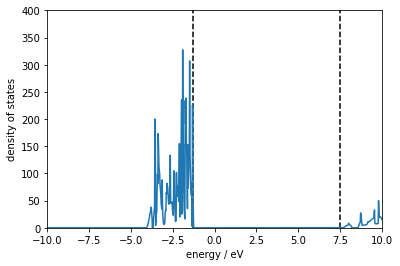

In [2]:
# manual DOS object generation

from vasppy.doscar import Doscar
from py_sc_fermi.dos import DOS
import numpy as np
import matplotlib.pyplot as plt

host_doscar = Doscar('vasp_example_outputs/DOSCAR_SP.txt') # path to example (spin polarised) vasp output
vbm = host_doscar.efermi                                   # recover the vbm
edos = host_doscar.tdos                                    # get a dataframe which contains the total density of states of the material as a function of energy
unoccupied_states = edos[edos['energy'] > vbm]             # find the states that are unnocupied
cbm = unoccupied_states[unoccupied_states['up'] + unoccupied_states['down'] > 0.00001].iloc[0]['energy'] # find the lowest energy unnocupied state
bandgap = cbm - vbm # bandgap as the difference between the highest occupied state and lowest unnocupied state

dos = DOS(np.array(edos['up']) + np.array(edos['down']), np.array(edos['energy']), bandgap, nelect=320) # generate DOS object.

# plot different attributes of the `dos` (DOS object) to ensure it looks as 
# we would expect a DOS function to look

plt.plot(dos.edos,dos.dos)
plt.vlines(vbm, 0, 1000, color = 'black', ls='--')
plt.vlines(cbm, 0, 1000, color = 'black', ls='--')
plt.xlim(-10,10)
plt.ylim(0,400)
plt.xlabel('energy / eV')
plt.ylabel('density of states')

## 3. Using VASP output parsing tools

This cell below gives an example of a convenince function availabe for vasp users for generating a `py_sc_fermi.dos.DOS` object directly from a vasprun.

/home/alex/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pymatgen/io/vasp/outputs.py:1014: UserWarning: No POTCAR file with matching TITEL fields was found in /mnt/a/materials_2/py-sc-fermi/examples/vasp_example_outputs
  warnings.warn("No POTCAR file with matching TITEL fields" " was found in {}".format(os.path.abspath(p)))


(0.0, 400.0)

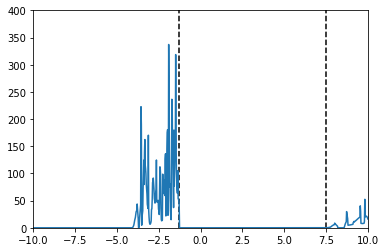

In [3]:
from py_sc_fermi.dos import DOS_from_vasprun

# DOS_from_vasprun 

dos = DOS_from_vasprun('vasp_example_outputs/vasprun_nsp.xml',320)

plt.plot(dos.edos,dos.dos)
plt.vlines(vbm, 0, 1000, color = 'black', ls='--')
plt.vlines(cbm, 0, 1000, color = 'black', ls='--')
plt.xlim(-10,10)
plt.ylim(0,400)

For calculating defect concentrations we also need to know volume of the pristine material. We can either calculate this by hand, or use a tool. Notably, this tool is a wrapper for `pymatgen` structure parsing, so reconises any structure file format that pymatgen is able to parse, including, but not limited to, vasp formatted structures (i.e `POSCAR` files), `.cif` files, `netcfd` files etc.

In [5]:
from py_sc_fermi.inputs import volume_from_structure

volume = volume_from_structure('vasp_example_outputs/vasprun.xml')

/home/alex/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pymatgen/io/vasp/outputs.py:1014: UserWarning: No POTCAR file with matching TITEL fields was found in /mnt/a/materials_2/py-sc-fermi/examples/vasp_example_outputs
  warnings.warn("No POTCAR file with matching TITEL fields" " was found in {}".format(os.path.abspath(p)))


## 4. Defect analysis

### i. defect formation energies

This cell calculates defect formation energies for lithium and flourine vacancies in LiF using a mix of calculated materials project data (not recommended, merely used as part of the MWE). None of this is dependant on py_sc_fermi functionaility, it is just necessary pre-processing. 

In [27]:
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.phase_diagram import PhaseDiagram
from pymatgen.core import Element, Composition

# output energies from the calculations generated in the
# first cell in this notebook

host_DFT_energy = -308.50975379
v_F_DFT_energy = -304.63905419
v_Li_DFT_energy = -302.53048584

# calculate "raw" energy difference between the calculation
# with the defect, and the host structure

raw_v_F_energy = v_F_DFT_energy - host_DFT_energy
raw_v_Li_energy = v_Li_DFT_energy - host_DFT_energy

# This initializes the MP REST adaptor. Put your own API key in if necessary.
# This is used to retrieve pahse stability information from the Materials proejct

mp_rest = MPRester()

# This gets all entries belonging to the Li-F system.
# and then retrieve the chemical potential stability limits of 
# LiF

all_entries = mp_rest.get_entries_in_chemsys(['Li','F'])
phase_diagram = PhaseDiagram(all_entries)
chemical_potentials = phase_diagram.get_chempot_range_stability_phase(Composition({'Li':1,'F':1}),Element['F'])

# calculate defect formation energies, using phase stability information, electronic information
# and the raw defect energies.

defect_formation_energy_v_F = raw_v_F_energy + 1 * chemical_potentials[Element['F']][0] + 1 * vbm
defect_formation_energy_v_Li = raw_v_Li_energy - 1 * chemical_potentials[Element['Li']][0] + -1 * vbm

### ii. self-consistent Fermi energy and transition level diagrams

We now reach the core functionality of `py_sc_fermi`, in which we generate a `DefectSystem` object, the inputs of this object:

- a list of `py_sc_fermi.defect_species.DefectSpecies`
    - the inputs for this are 
    - a label for the defect, i.e. we have chosen to label a lithium vacancy as "v_Li"
    - the site degeneracy of the defect, i.e. how many degenerate sites in the calculation cell that could host this defect
    - a list of `py_sc_fermi.defect_charge_state.DefectChargeState` objects which are comprised of:
            - charge state of the defect
            - the formation energy of the charge state at E_Fermi = 0
            - (spin) dengeneracies of the charge state.
    - the dos object (see section 2)
    - the volume of the calculation cell (see section 3)
    - the temperature at which the defect concentrations should be calculated
    - whether or not the defect system represents a spin polarised vasp calculation (1 = non-spin polarised, 2 = spin-polarised)
    
using this defect system, we solve for the self consistent Fermi energy, and then plot it on the transition level diagram. 

Text(0, 0.5, 'E_formation / eV')

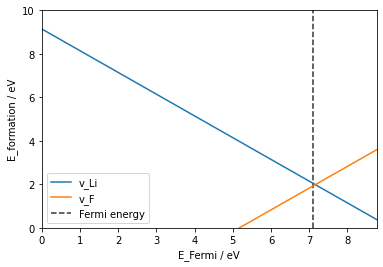

In [46]:
from py_sc_fermi.defect_system import DefectSystem
from py_sc_fermi.defect_species import DefectSpecies
from py_sc_fermi.defect_charge_state import DefectChargeState

v_Li = DefectSpecies('v_Li', 32, [DefectChargeState(-1, defect_formation_energy_v_Li, 1)])
v_F = DefectSpecies('v_F', 32, [DefectChargeState(1, defect_formation_energy_v_F, 1)])
defect_system = DefectSystem([v_Li, v_F], dos, volume, temperature=1000, spin_pol=1)

sc_fermi_energy = (defect_system.get_sc_fermi(verbose=False))
plt.plot(defect_system.get_transition_levels()['v_Li'][0], defect_system.get_transition_levels()['v_Li'][1], label = 'v_Li')
plt.plot(defect_system.get_transition_levels()['v_F'][0], defect_system.get_transition_levels()['v_F'][1], label = 'v_F')
plt.xlim(0, cbm-vbm)
plt.ylim(0,10)
plt.vlines(sc_fermi_energy,0,10,color='#333333',ls='--', label='Fermi energy')

plt.legend(loc = 'lower left')
plt.xlabel('E_Fermi / eV')
plt.ylabel('E_formation / eV')

### iii. sweeping parameter space with py-sc-fermi

the whole core functionality of `py-sc-fermi` is contained within the cell above. The key advantage of the method is that it allows for sweeping of a parameter space, e.g. temperature or chemical potential space in a very straightforward manner. The cell below shows how to do this for the example of temperature.

/mnt/a/materials_2/py-sc-fermi/py_sc_fermi/dos.py:96: RuntimeWarning: overflow encountered in exp
  return dos / (1.0 + np.exp((e_fermi - edos)/kT))


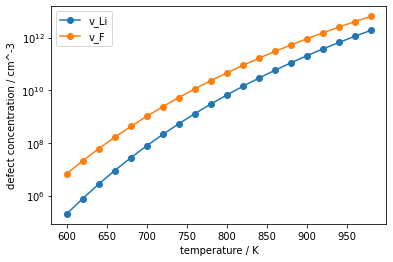

In [50]:
from py_sc_fermi.defect_system import DefectSystem
from py_sc_fermi.defect_species import DefectSpecies
from py_sc_fermi.defect_charge_state import DefectChargeState

v_Li = DefectSpecies('v_Li', 32, [DefectChargeState(-1, defect_formation_energy_v_Li, 1)])
v_F = DefectSpecies('v_F', 32, [DefectChargeState(1, defect_formation_energy_v_F, 1)])

v_li_concentrations = []
v_f_concentrations = []
for temperature in np.arange(600,1000,20):
    defect_system = DefectSystem([v_Li, v_F], dos, volume, temperature=temperature, spin_pol=1)
    defect_system_data = defect_system.to_dict()
    v_li_concentrations.append(defect_system_data['v_Li'])
    v_f_concentrations.append(defect_system_data['v_F'])


plt.yscale('log')
plt.xlabel('temperature / K')
plt.ylabel('defect concentration / cm^-3')
    
plt.plot(np.arange(600,1000,20),v_li_concentrations, '-o', label = 'v_Li')
plt.plot(np.arange(600,1000,20),v_f_concentrations, '-o', label = 'v_F')

plt.legend()
plt.show()

### iv. frozen concentration defects

An additional functionality available in `py_sc_fermi` (as implemented in FORTRAN code [SC-Fermi](https://github.com/jbuckeridge/sc-fermi)) is to fix the concentration of a given defect, charge state or introduce a new defect entirely with a fixed charge state. This can be used to model how the defect chemistry responds to e.g. the introduction of an aliovalent dopant. As an example, see:

- https://doi.org/10.1021/acs.chemmater.9b04319

/mnt/a/materials_2/py-sc-fermi/py_sc_fermi/dos.py:96: RuntimeWarning: overflow encountered in exp
  return dos / (1.0 + np.exp((e_fermi - edos)/kT))


Text(0, 0.5, 'defect concentration / cm^3')

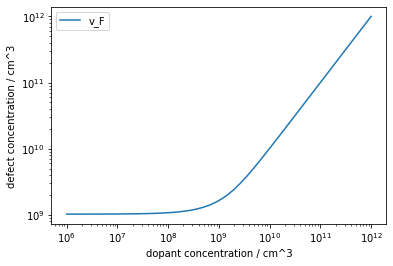

In [54]:
from py_sc_fermi.defect_charge_state import FrozenDefectChargeState

dopant_concentrations = np.logspace(6,12)

v_li_concentrations = []
v_f_concentrations = []
for dopant_concentration in dopant_concentrations:
    dopant_charge_state = FrozenDefectChargeState(1,dopant_concentration/1e24 * defect_system.volume)
    defect_system = DefectSystem([v_Li, v_F, DefectSpecies('dopant',-1,[dopant_charge_state])], dos, volume, temperature=700, spin_pol=1)
    defect_system_data = defect_system.to_dict()
    v_li_concentrations.append(defect_system_data['v_Li'])
    v_f_concentrations.append(defect_system_data['v_F'])

plt.yscale('log')
plt.xscale('log')
plt.plot(dopants,v_f_concentrations, label = ('v_F'))

plt.legend()
plt.xlabel('dopant concentration / cm^3')
plt.ylabel('defect concentration / cm^3')